## Get data and packages

In [1]:
import os

os.chdir(os.path.join(os.getcwd(), '..'))
import src.preprocessing
import src.model_training
import src.feature_engineering

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time
import shap
import lightgbm as lgb
import joblib

import json
import sys

from verstack import LGBMTuner
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = src.feature_engineering.get_train_data('data/data_pricing_challenge.csv')
df.head()

,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at,diesel,electro,hybrid_petrol,petrol,beige,black,blue,brown,green,grey,orange,red,silver,white,convertible,coupe,estate,hatchback,sedan,subcompact,suv,van,antiquity,avg_price,avg_mileage,avg_antiquity,avg_engine_power
0,140411,100,2012-02-01,diesel,black,convertible,1,1,0,0,1,1,1,0,11300,2018-01-01,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,5.916496,9768.79,130799.10,6.19,103.42
1,13929,317,2016-04-01,petrol,grey,convertible,1,1,0,0,0,1,1,1,69700,2018-02-01,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1.837098,61650.00,41669.50,2.46,317.00
2,183297,120,2012-04-01,diesel,white,convertible,0,0,0,0,1,0,1,0,10200,2018-02-01,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,5.837098,12427.21,153493.65,5.64,126.22
3,128035,135,2014-07-01,diesel,red,convertible,1,1,0,0,1,1,1,1,25100,2018-02-01,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,3.589322,23931.82,86178.64,3.74,132.20
4,97097,160,2014-12-01,diesel,silver,convertible,1,1,0,0,0,1,1,1,33400,2018-04-01,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,3.331964,31000.00,76673.50,3.38,160.00


Model Training

In [3]:
target = 'price'
variables = src.model_training.txt_load('utils/model_variables.txt')
hyperparameters = src.model_training.json_load('utils/model_hyperparameters.json')

# Add L1 and L2 regularization
# hyperparameters['reg_alpha'] = 0.8
# hyperparameters['reg_lambda'] = 0.1

X = df.loc[:, variables]
y = df.loc[:, [target]]


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 5295.5014072644435
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 2637.449284128663
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 2634.477252796317
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmse: 4229.821657515407
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmse: 2600.217981574044
 ..................................................

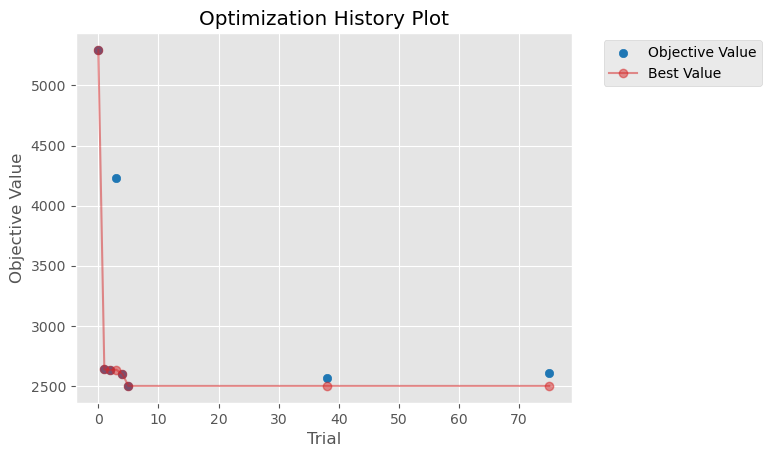

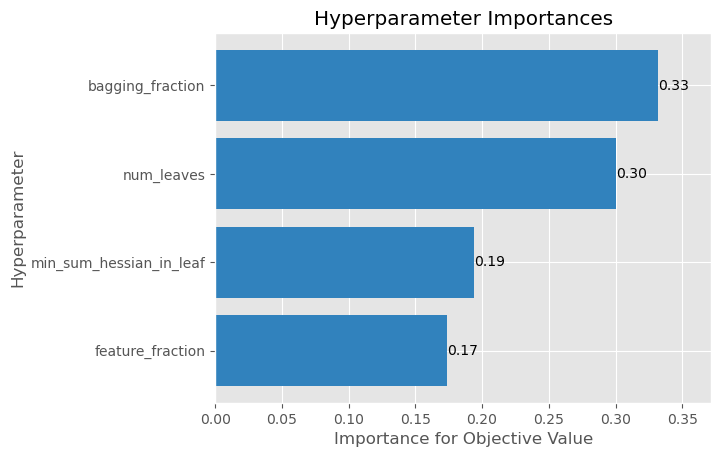

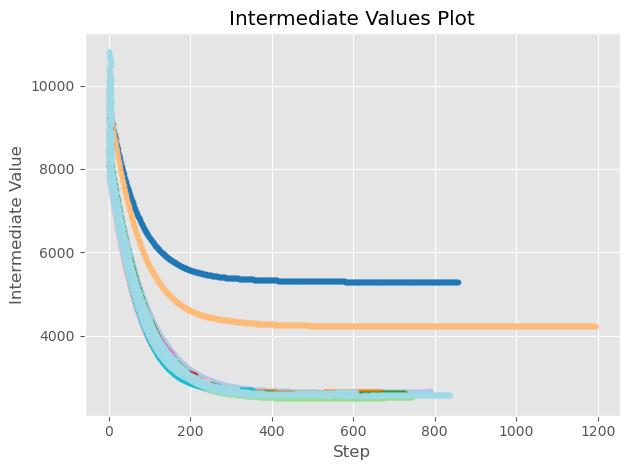

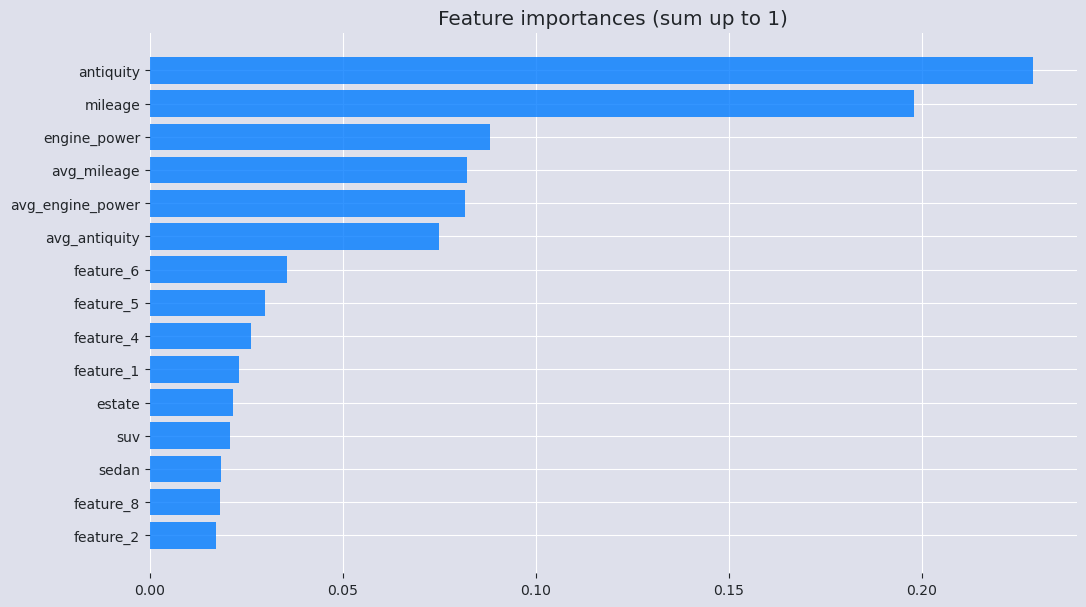


     . Optuna hyperparameters optimization finished
     .. Best trial number: 5    |     rmse:            2500.412396898581
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 52.44769 seconds


In [4]:
# Initial tune to optimize hyperparameters

# tuner = LGBMTuner(metric = 'rmse', random_state = 123)
# tuner.fit(X, y['price'])

In [5]:
X_train, X_test, y_train, y_test = src.model_training.split_dataset(df, variables, target, 0.3)

In [6]:
model = src.model_training.lightgbm_training(X_train, y_train, hyperparameters)

In [7]:
results = X_test.copy()
results = results.assign(
    price_real = y_test,
    price_pred = model.predict(X_test)
)
results['error'] = results['price_real'] - results['price_pred']
results.sort_values(by='error', ascending = True).head(10)

,mileage,engine_power,antiquity,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,estate,hatchback,sedan,suv,avg_mileage,avg_antiquity,avg_engine_power,price_real,price_pred,error
4726,97835,190,5.251198,1,1,1,0,0,0,0,1,0,0,0,1,134557.10,5.46,134.44,5400,24869.131763,-19469.131763
2132,64985,230,2.080767,1,1,1,1,0,1,1,1,0,1,0,0,56066.17,3.00,227.50,34500,53209.170423,-18709.170423
3544,40142,280,1.998631,1,1,1,1,1,1,1,1,0,0,1,0,141101.33,4.20,280.00,41100,57489.795174,-16389.795174
3961,58117,230,4.000000,1,1,0,0,1,1,1,1,0,0,0,1,81386.78,3.15,153.91,28700,44084.079650,-15384.079650
2641,47317,230,2.171116,1,1,1,1,0,0,1,1,0,0,1,0,120806.22,4.15,230.00,44600,59228.395251,-14628.395251
2417,88092,120,5.251198,1,1,1,0,1,0,1,1,0,1,0,0,138155.43,4.71,126.52,8400,20537.153468,-12137.153468
3911,152658,180,4.418891,1,1,0,1,1,1,1,1,0,0,0,1,130993.32,5.64,189.09,24400,34621.537479,-10221.537479
1503,132302,85,5.494867,1,1,0,0,0,1,1,0,1,0,0,0,139846.71,5.04,85.02,1300,10300.714595,-9000.714595
4583,71037,140,3.915127,1,1,0,0,1,0,1,0,0,0,0,1,81386.78,3.15,153.91,23800,32764.038039,-8964.038039
2061,66690,135,3.832991,1,1,0,1,1,0,1,0,0,1,0,0,81601.36,3.23,133.18,13200,22113.242182,-8913.242182


In [8]:
import plotly.express as px

max_value = 70000

fig = px.scatter(results, x='price_real', y='price_pred', title='Price Real vs Pred', width = 700, height = 700)

# Agregar la línea y=x en rojo
fig.add_trace(px.line(x=[0, max_value], y=[0, max_value]).update_traces(line_shape='linear', line_color='red').data[0])

fig.update_xaxes(range=[0, max_value])
fig.update_yaxes(range=[0, max_value])

fig.show()

Plots and Model Performance Analysis

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

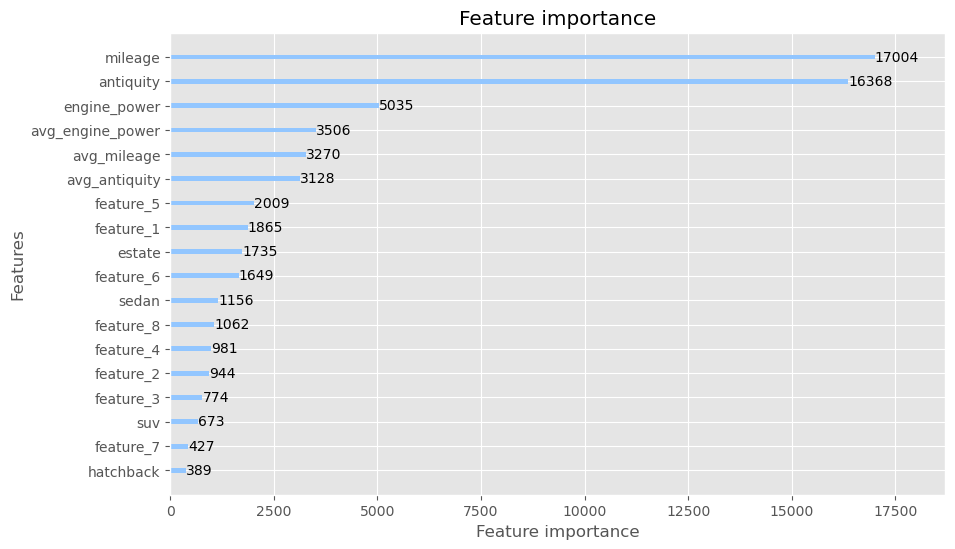

In [9]:
lgb.plot_importance(model, max_num_features=30, figsize=(10, 6))

In [10]:
src.model_training.model_results(model, X_train, X_test, y_train, y_test)

Model Results:

RMSE train: 3377.922257434325
RMSE test: 2737.5692747365324

MAE train: 1242.1251848822146
MAE test: 1728.8835849061243

R2 train: 0.8716846816833517
R2 test: 0.8879549109382575


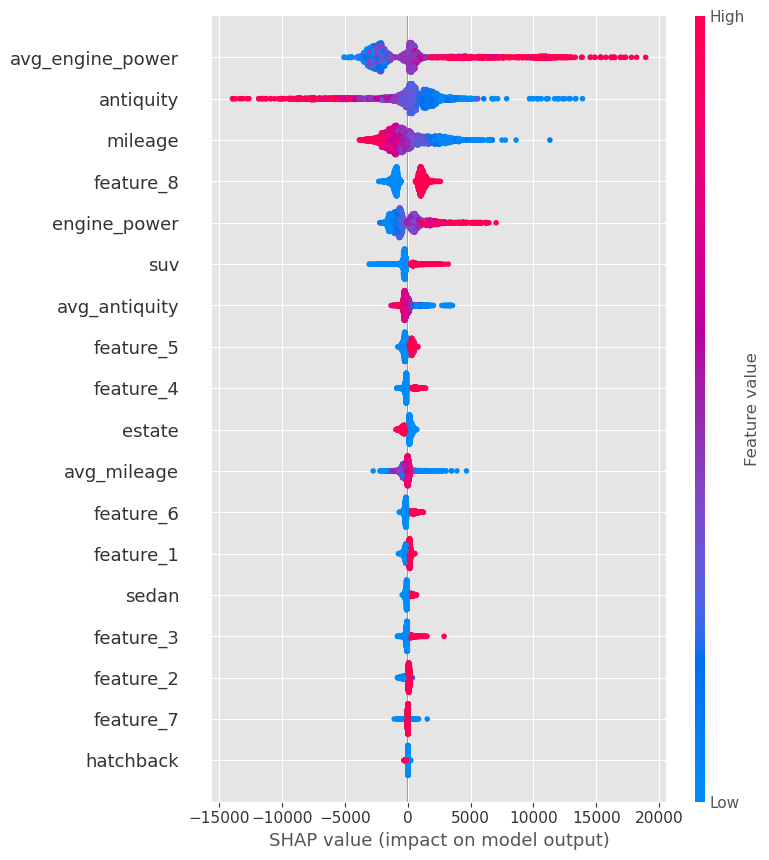

In [11]:
explainer, shap_values = src.model_training.calculate_shap_values(model, X_train)

# Visualize Shapley values
shap.summary_plot(shap_values, X_train)

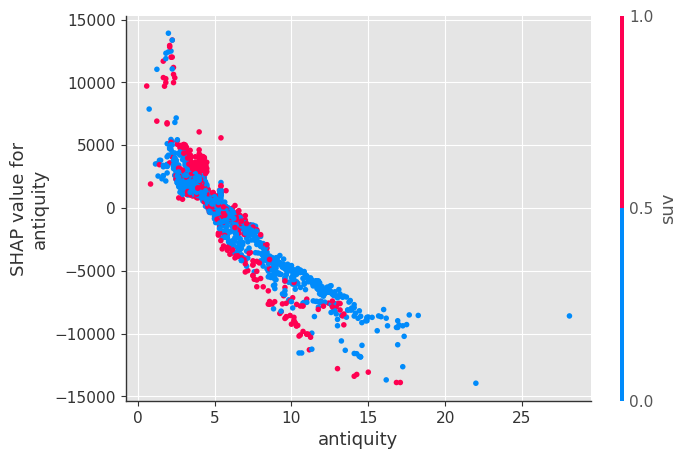

In [12]:
feature_names = X_train.columns.tolist()

# Seleccionar las variables que te interesan (puedes usar los nombres directamente)
variable1_name = 'antiquity'
variable2_name = 'suv'

# Encontrar los índices correspondientes a los nombres de las variables
variable1_index = feature_names.index(variable1_name)
variable2_index = feature_names.index(variable2_name)

# Crear un Dependence Plot
shap.dependence_plot(variable1_index, shap_values, X_train, feature_names=feature_names, interaction_index=variable2_index, show=False)
plt.show()

In [13]:
src.model_training.save_model(model, '\model')

## Notes

After iterating with different models (baseline model is available at '/models' folder), final one is using variables available at ('/utils/mode_variables.txt').

Model predictions adjusts correctly to reality, but RMSE is still too high depending on certain business needs.

Tu upgrade the model, a wider set of data would be necessary. At the moment, the model may have difficulty capturing the true relationship between characteristics and target variable.
Additionally, new features could be collected as well, such as initial price.